In [22]:
#!pip install category_encoders
import category_encoders
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import mimetypes
import seaborn as sns 
import pickle

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score

#! pip install xgboost
from xgboost import XGBClassifier

import warnings

In [2]:
color_list = ['#F8C471','#F1948A', '#7FB3D5', '#D2B4DE', '#A2D9CE']

### Table of contents
[1. Preserving your model](#1.-Preserving-your-model)   
[2. Train your model](#2.-Train-your-model)   
&emsp;[2.1 Let's build the pipeline](#2.1-Let's-build-the-pipeline)   
&emsp;[2.2 Predicting on new observations](#2.2-Predicting-on-new-observations)   
[3. Serialization of the necessary components](#3.-Serialization-of-the-necessary-components)   
&emsp;[3.1 Serializing the columns in the correct order](#3.1-Serializing-the-columns-in-the-correct-order)   
&emsp;[3.2 Serializing the fitted pipeline](#3.2-Serializing-the-fitted-pipeline)   
&emsp;[3.3 Serializing the dtypes of the columns](#3.3-Serializing-the-dtypes-of-the-columns)

# 1. Preserving your model

In this learning unit you will learn how to preserve your model so that the value it generates can be used in a separate process or program than the one in which it was fitted. There are a few different ways to do this but for this specialization we will be using the following tools:

1. [pickle](https://docs.python.org/3/library/pickle.html) from python core
1. [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators) from scikit

This will be our journey:

1. **Train**: We are going to first train a model on the classic titanic dataset. We will use this one because it has categorical and numeric features, and missing values in both types.

2. **Serialize**: Once the model has been trained as part of a pipeline, we will [serialize] https://en.wikipedia.org/wiki/Serialization) it using the [pickle](https://docs.python.org/3/library/pickle.html) package that is found in python's core.

3. **Predict on new data**: After we are confident we can retrieve the pickled model from the disk, we will show how to prepare a brand new observation for prediction with the model.

# 2. Train your model

In [3]:
df = pd.read_csv('data/data_clean.csv').set_index('observation_id')
df.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,hour,month,day_of_week,period,target
observation_id,,,,,,,,,,,,,,,,
696ca8c4-6934-48d2-8c73-04af064992ce,person and vehicle search,2020-02-01 00:00:00+00:00,False,51.691896,-4.952055,male,over 34,white,misuse of drugs act 1971 (section 23),controlled drugs,dyfed-powys,0,2,Saturday,Late Night,False
b399fbcb-c27e-420b-b5ef-98f501765fc6,person search,2020-02-01 00:00:00+00:00,False,50.785798,0.263758,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
29b57000-40bf-458f-91fd-35f7c292f5e7,person search,2020-02-01 00:00:00+00:00,False,50.784128,0.291258,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
2ccc1515-e2ed-45c4-a810-8e72f93cde50,person and vehicle search,2020-02-01 00:00:00+00:00,False,50.846339,0.469754,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
72853059-43dd-4594-8183-21c4cb68ca2a,person search,2020-02-01 00:00:00+00:00,False,54.853138,-6.694079,female,over 34,white,misuse of drugs act 1971 (section 23),controlled drugs,sussex,0,2,Saturday,Late Night,False


In [4]:
features =  ['Type',
             'Part of a policing operation',
             'Latitude',
             'Longitude', 
             'Gender', 
             'Age range', 
             'Officer-defined ethnicity', 
             'Legislation', 
             'Object of search', 
             'station',
             'hour', 
             'month', 
             'day_of_week',
             'period']

#### Train/Validation Split

In [5]:
X = df[features]
y = df['target']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify = y #df['station']
                                                 )

In [7]:
y_val.value_counts(normalize=True)

False    0.817554
True     0.182446
Name: target, dtype: float64

In [8]:
y_train.value_counts(normalize=True)

False    0.817558
True     0.182442
Name: target, dtype: float64

In [9]:
X_train['day_of_week'].unique()

array(['Tuesday', 'Thursday', 'Saturday', 'Sunday', 'Wednesday', 'Friday',
       'Monday'], dtype=object)

#### Creating the Pipeline

In [473]:
numerical_columns = ['Latitude', 
                     'Longitude', 
                     'hour', 
                     'month']
categorical_columns = [#'day_of_week',
                       #'period'
                      ]
categorical_oe_columns = [
                          'Part of a policing operation',
                          'Type', 
                          #'Gender', 
                          #'Age range', 
                          #'Officer-defined ethnicity', 
                          'Legislation', 
                          'Object of search',    
                          'station',
                          'day_of_week', 
                          'period',
                         ]

In [474]:
num_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [475]:
cat_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[[ 'Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
                                           #['Late Night', 'Early Morning', 'Morning', 'Noon', 'Evening', 'Night']
                                          ], 
                               handle_unknown='use_encoded_value',
                               unknown_value = -1))
])

In [476]:
cat_transformer_oh = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [477]:
preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, numerical_columns),
    ('cat', cat_transformer, categorical_columns),
    ('cat_oh', cat_transformer_oh, categorical_oe_columns)
    ]
)

In [478]:
pipeline_lr = Pipeline([("preprocessor", preprocessor),
                        ('classifier_LogisticRegression', LogisticRegression(solver='liblinear', random_state=42))])

pipeline_rf = Pipeline([("preprocessor", preprocessor),
                        ('classifier_RandomForest', RandomForestClassifier(random_state=42,
                                                   n_estimators = 500,
                                                   min_samples_split = 1575,
                                                   min_samples_leaf = 100,
                                                   max_depth = 10,
                                                   max_features = 19))])

pipeline_gb = make_pipeline(preprocessor,
                        GradientBoostingClassifier(random_state=42,
                                                   n_estimators = 500,
                                                   learning_rate = 0.1,
                                                   min_samples_split = 1575,
                                                   min_samples_leaf = 100,
                                                   max_depth = 10,
                                                   max_features = 19,
                                                   subsample=0.8),)

pipeline_xgb = make_pipeline(preprocessor,
                             XGBClassifier(learning_rate = 0.1,
                                           n_estimators = 250,
                                           max_depth= 9, 
                                           min_child_weight = 1,
                                           gamma = 0,
                                           subsample = 0.8,
                                           colsample_bytree = 0.8,
                                           objective= 'binary:logistic', 
                                           nthread = -1, 
                                           scale_pos_weight = 1,
                                           reg_alpha = 1e-5,
                                           seed=42))

pipelines = [pipeline_lr, 
             pipeline_rf, 
             pipeline_gb, 
             pipeline_xgb]
pipe_dict = {0: 'Logistic Regression', 1:'Random Forest', 2: 'Gradient Boosting', 3: 'XGB Classifier'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

Logistic Regression
ROC_AUC:	 0.6568682271363738
Threshold:	 0.07540216851382818
Precision:	 0.2
Recall:		 0.9773211495667818


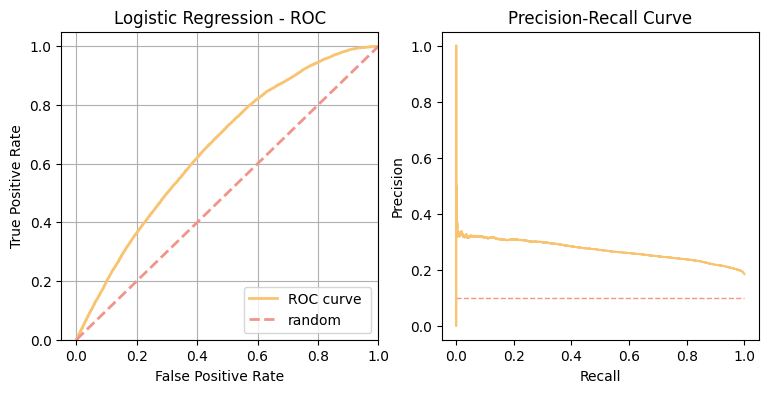

Random Forest
ROC_AUC:	 0.6643172769172352
Threshold:	 0.08432734733028759
Precision:	 0.2
Recall:		 0.9841863548127456


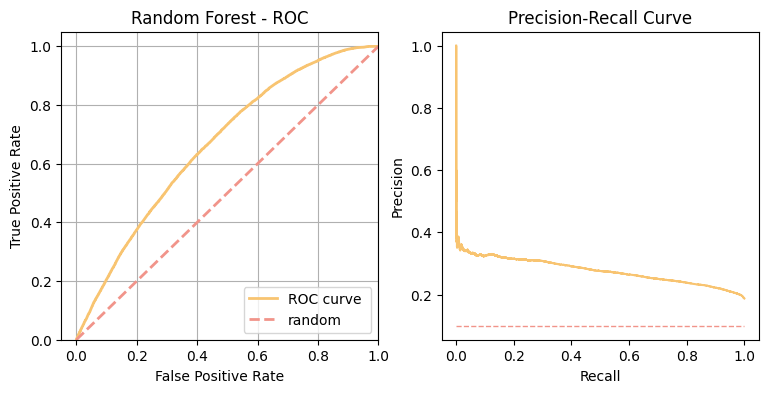

Gradient Boosting
ROC_AUC:	 0.6773265222610672
Threshold:	 0.04988144437032286
Precision:	 0.2
Recall:		 0.9882581317172482


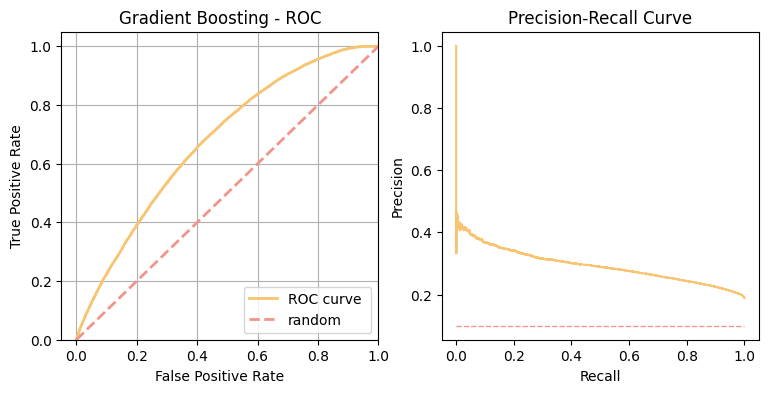

XGB Classifier
ROC_AUC:	 0.6801346999990188
Threshold:	 0.051826295
Precision:	 0.2
Recall:		 0.9887789403910799


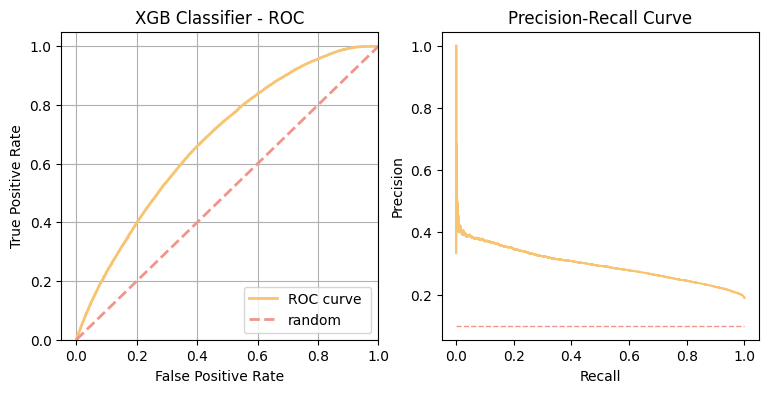


----------------------------------------------------------
Classifier with the best ROC-AUC: XGB Classifier Classifier



In [479]:
best_roc_auc = 0.0
best_classifier = 0
best_pipeline = ''
prediction_dict={}

for i, model in enumerate (pipelines) : 
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    
    fpr, tpr, threshold = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

    print(pipe_dict[i])
    print("ROC_AUC:\t", roc_auc)
    prediction_dict[pipe_dict[i]]=[y_proba, roc_auc]

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_pipeline = model
        best_classifier = i   
    
    min_index = [i for i, prec in enumerate(precision) if prec >= 0.2][0]
    print("Threshold:\t" , thresholds[min_index])
    print("Precision:\t" ,precision[min_index])
    print("Recall:\t\t", recall[min_index])

    
    #create Plot
    fig = plt.figure(figsize=(9,4))    
 
    axes = fig.add_subplot(1,2,1)
    axes = plt.plot(fpr, tpr, color='#F8C471', lw=2, label='ROC curve ')
    axes = plt.plot([0, 1], [0, 1], color = '#F1948A', lw=2, linestyle='--', label='random')
    axes = plt.xlim([-0.05, 1.0])
    axes = plt.ylim([0.0, 1.05])
    axes = plt.grid()
    axes = plt.xlabel('False Positive Rate')
    axes = plt.ylabel('True Positive Rate')
    axes = plt.title("{} - ROC".format(pipe_dict[i]))
    axes = plt.legend(loc="lower right")
    
    axes = fig.add_subplot(1,2,2)
    axes = plt.plot(recall, precision, color='#F8C471')
    axes = plt.hlines(y=0.1, xmin=0, xmax=1, linewidth=1, color = '#F1948A', linestyle="--")
    axes = plt.title('Precision-Recall Curve')
    axes = plt.ylabel('Precision')
    axes = plt.xlabel('Recall')

    plt.show()    
    
print('\n----------------------------------------------------------')
print('Classifier with the best ROC-AUC: {} Classifier\n'.format(pipe_dict[best_classifier]))

In [464]:
#pipeline = pipeline_lr
#pipeline = pipeline_rf
#pipeline = pipeline_gb
pipeline = pipeline_xgb

In [465]:
threshold = thresholds[min_index]
#threshold = 0.22359079294352646
y_threshold = pd.Series([True if p >= threshold else False for p in y_proba]).to_numpy()

In [466]:
threshold

0.055690024

### Business Requirements Validation

####  Precision higher or equal to 10% per police station and search objective

In [467]:
def CalculatePrecision(y_true, y_pred, threshold = 0.1):
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    threshold_fulfilled = (precision >= threshold)
    
    return precision, recall, threshold_fulfilled

In [468]:
precision, recall, threshold_fulfilled = CalculatePrecision(y_val, y_threshold)

print("Global Precision: {}".format((threshold_fulfilled, precision)))
print("Global Recall: {}".format(recall))

Global Precision: (True, 0.2)
Global Recall: 0.9843283935419724


In [469]:
def verify_precision_per_station_object(X_test, y_true, y_pred, sensitive_column='Object of search', min_precision=0.1, min_samples=50):
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff < min_precision:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
            
    station_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            station_precisions[department] = precision_score(y_true[mask], y_pred[mask])
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff < min_precision:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions, station_precisions

In [470]:
warnings.filterwarnings('ignore')

is_satisfied, problematic_departments, good_deparments, global_precisions, station_precisions = verify_precision_per_station_object(
    X_val, y_val, y_threshold)


print("Object of search")

#if not is_satisfied:
print("Requirement failed 😢")
print("Global rates: {}".format(global_precisions))
print("Num problematic departments: {}".format(len(problematic_departments)))
print("Num good departments: {}".format(len(good_deparments)))
print("avg diff:", np.mean([p[1] for p in problematic_departments]))
print("\nStation rates: {}".format(station_precisions))
print('Maximum diference: {}'.format(max(station_precisions.values()) - min(station_precisions.values())))
print('Stations that fulfill: {}'.format(np.sum([1 for sp in station_precisions.values() if sp >= 0.1 ])))

Object of search
Requirement failed 😢
Global rates: {'controlled drugs': 0.2252344646110249, 'offensive weapons': 0.11007751937984496, 'stolen goods': 0.20037507212925562, 'firearms': 0.11702127659574468, 'articles for use in criminal damage': 0.09674329501915709, 'evidence of offences under the act': 0.12549019607843137, 'article for use in theft': 0.1123869671307593, 'psychoactive substances': 0.2343211578221916, 'anything to threaten or harm anyone': 0.09583608724388631, 'detailed object of search unavailable': 0.25, 'game or poaching equipment': 0.22666666666666666, 'fireworks': 0.08955223880597014}
Num problematic departments: 4
Num good departments: 33
avg diff: 0.07759682273332226

Station rates: {'cheshire': 0.24776500638569604, 'merseyside': 0.1646540157178455, 'west-yorkshire': 0.1695710455764075, 'cleveland': 0.14596554850407978, 'west-midlands': 0.03938730853391685, 'warwickshire': 0.2563176895306859, 'north-yorkshire': 0.1885488647581441, 'suffolk': 0.1932259855635758, 'av

#### Discrepancy lower than 5% per police station between the success rate of protected classes (ethnicity, gender)

In [471]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=50):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions



In [472]:
warnings.filterwarnings('ignore')

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold)


print("Officer-defined Ethnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold, sensitive_column='Gender')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

print("\n\nAge Range")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold, sensitive_column='Age range')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))        

Officer-defined Ethnicity
Requirement failed 😢
Global rates: {'white': 0.19988161740224186, 'asian': 0.1907648782459331, 'black': 0.2093297903749631, 'mixed': 0.23488372093023255, 'other': 0.18772563176895307}
Num problematic departments: 19
Num good departments: 15
avg diff: 0.08588572974510306


Gender
Requirement failed 😢
Global rates: {'male': 0.20304579595129343, 'female': 0.17681810617407223, 'other': 0.19597989949748743}
Num problematic departments: 7
Num good departments: 30
avg diff: 0.08063998465123538


Age Range
Requirement failed 😢
Global rates: {'18-24': 0.2365985780385961, 'over 34': 0.17669203367875647, 'under 18': 0.14398521505376344, '25-34': 0.21074539428042857}
Num problematic departments: 36
Num good departments: 1
avg diff: 0.11204538565509933
Departments analysed: 37


### Feature Importance

In [430]:
pipeline.named_steps['xgbclassifier']

KeyError: 'xgbclassifier'

In [394]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__cat_oh', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__verbose', 'columntransformer__num__fillna', 'columntransformer__num__scaler', 'columntransformer__num__fillna__add_indicator', 'columntransformer__num__fillna__copy', 'columntransformer__num__fillna__fill_value', 'columntransformer__num__fillna__missing_values', 'columntransformer__num__fillna__strategy', 'columntransformer__num__fillna__verbose', 'columntransformer__num__scaler__copy', 'columntransformer__num__scaler__quantile_range', 'columntransformer__num__scaler__unit_variance', 'columntransformer__num__scaler__with_centering', 'c

In [398]:
gb_step.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity', 'nthread', 'seed'])

Feature ranking:
1. feature station_west-midlands (0.103838)
2. feature station_south-yorkshire (0.085304)
3. feature station_dyfed-powys (0.076199)
4. feature Object of search_controlled drugs (0.075294)
5. feature station_hampshire (0.048355)
6. feature station_lincolnshire (0.033626)
7. feature Legislation_police and criminal evidence act 1984 (section 1) (0.022892)
8. feature Object of search_stolen goods (0.021148)
9. feature station_merseyside (0.020189)
10. feature station_kent (0.019105)


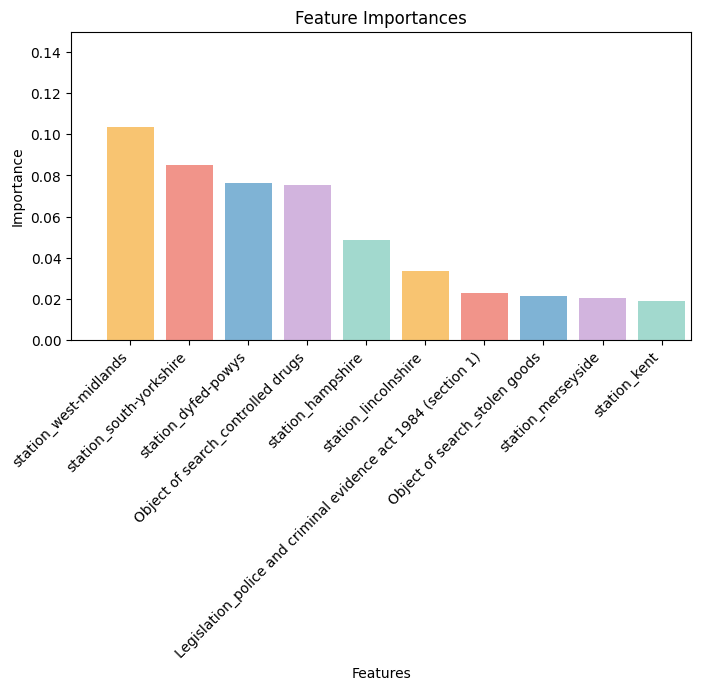

In [399]:
ordinal_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['ordinal']
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat_oh'].named_steps['onehot']
gb_step = pipeline.named_steps['xgbclassifier']

onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_oe_columns)

importances = pd.Series(data = gb_step.feature_importances_, 
                        index = np.array(numerical_columns + list(categorical_columns) + list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

#print(indices)
plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color= color_list, align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, 9.5])
plt.ylim([0, 0.15])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()

### Hyperparameter Optimization

In [37]:
grid_gb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__cat_oh', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__verbose', 'columntransformer__num__fillna', 'columntransformer__num__scaler', 'columntransformer__num__fillna__add_indicator', 'columntransformer__num__fillna__copy', 'columntransformer__num__fillna__fill_value', 'columntransformer__num__fillna__missing_values', 'columntransformer__num__fillna__strategy', 'columntransformer__num__fillna__verbose', 'columntransformer__num__scaler__copy', 'columntransformer__num__scaler__quantile_range', 'columntransformer__num__scaler__unit_variance', 'columntransformer__num__scaler__with_centering', 'c

In [23]:
def modelfit(alg, Xtrain, ytrain, performCV=False, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(Xtrain, ytrain)
        
    #Predict training set:
    dtrain_predictions = alg.predict(Xtrain)
    dtrain_predprob = alg.predict_proba(Xtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, Xtrain, ytrain, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(ytrain.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(ytrain, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

param_test1 = {'gradientboostingclassifier__n_estimators':range(100,500,50)} 300

param_test2 = {'gradientboostingclassifier__max_depth':range(5,16,5), 
               'gradientboostingclassifier__min_samples_split':range(0,3001,500)}
               
param_test3 = {'gradientboostingclassifier__min_samples_split':range(1500,1600,25), #1600
               'gradientboostingclassifier__min_samples_leaf':range(80,150,20)} #100
               
param_test4 = {'gradientboostingclassifier__max_features':range(7,20,2)}

param_test5 = {'gradientboostingclassifier__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

grid_gb = make_pipeline(preprocessor,
                        GradientBoostingClassifier(random_state=42,
                                                   n_estimators = 400,
                                                   learning_rate = 0.1,
                                                   min_samples_split = 1575,
                                                   min_samples_leaf = 100,
                                                   max_depth = 10,
                                                   max_features = 19,
                                                   subsample=0.9
                                                  ),)
                                                  
gsearch1 = GridSearchCV(estimator = grid_gb, param_grid = param_test5, scoring='roc_auc', n_jobs=-1, cv=5, verbose = 2)

modelfit(grid_gb, X_train,y_train)

#Optimize the learning rate, the number of trees, and the maximum depth of each tree.

param_test1 = {'xgbclassifier__max_depth':range(3,12,2), 
               'xgbclassifier__min_child_weight':range(1,6,2)} 

param_test2 = {'xgbclassifier__gamma':[i/10.0 for i in range(0,5)]}

param_test3 = {'xgbclassifier__subsample':[i/100.0 for i in range(75,90,5)],
               'xgbclassifier__colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

param_test4 = {'xgbclassifier__n_estimators': range(100,1200, 150)}

param_test5 = {'xgbclassifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
grid_gb = make_pipeline(preprocessor, 
                        XGBClassifier(learning_rate = 0.1, 
                                      n_estimators = 250,
                                      max_depth= 9, 
                                      min_child_weight = 1,
                                      gamma = 0,
                                      subsample = 0.8,
                                      colsample_bytree = 0.8,
                                      objective= 'binary:logistic', 
                                      nthread = -1, 
                                      scale_pos_weight = 1,
                                      reg_alpha = 1e-5,
                                      seed=42),) 

gsearch1 = GridSearchCV(estimator = grid_gb, 
                        param_grid = param_test5, 
                        scoring='roc_auc', 
                        n_jobs=-1, 
                        cv=5, verbose = 2) 

gsearch1.fit(X_train,y_train)

In [39]:
 gsearch1.best_params_, gsearch1.best_score_

({'xgbclassifier__reg_alpha': 1e-05}, 0.6741434763905869)

[CV] END .....................xgbclassifier__reg_alpha=1e-05; total time= 1.6min
[CV] END ......................xgbclassifier__reg_alpha=0.01; total time= 3.4min
[CV] END .........................xgbclassifier__reg_alpha=1; total time= 2.9min
[CV] END .....................xgbclassifier__reg_alpha=1e-05; total time= 1.6min
[CV] END .......................xgbclassifier__reg_alpha=0.1; total time= 3.5min
[CV] END .........................xgbclassifier__reg_alpha=1; total time= 2.9min
[CV] END .....................xgbclassifier__reg_alpha=1e-05; total time= 1.6min
[CV] END .......................xgbclassifier__reg_alpha=0.1; total time= 3.5min
[CV] END .........................xgbclassifier__reg_alpha=1; total time= 3.0min
[CV] END .....................xgbclassifier__reg_alpha=1e-05; total time= 1.6min
[CV] END .......................xgbclassifier__reg_alpha=0.1; total time= 3.5min
[CV] END .......................xgbclassifier__reg_alpha=100; total time= 2.6min
[CV] END ...................

## Serialization of the necessary components

In [480]:
pipeline_xgb = make_pipeline(preprocessor,
                             XGBClassifier(learning_rate = 0.1,
                                           n_estimators = 250,
                                           max_depth= 9, 
                                           min_child_weight = 1,
                                           gamma = 0,
                                           subsample = 0.8,
                                           colsample_bytree = 0.8,
                                           objective= 'binary:logistic', 
                                           nthread = -1, 
                                           scale_pos_weight = 1,
                                           reg_alpha = 1e-5,
                                           seed=42))

In [481]:
pipeline_xgb.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'hour', 'month']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['Monday',
                                                                                               'Tuesday',
                                                                       

#### Serializing the columns in the correct order

In [482]:
with open('columns.json', 'w') as fh:
    json.dump(X.columns.tolist(), fh)

#### Serializing the fitted pipeline

In [483]:
import joblib
joblib.dump(pipeline_xgb, 'pipeline.pickle') 

['pipeline.pickle']

**NOTE**. One thing to consider when serializing/deserializing scikit-learn estimators is that joblib/pickle don't store the definitions of the estimators (the code). This means 2 things:

- All of the libraries you use to build the pipeline on your laptop need to be available (installed) in the machine where you deploy it. 

- All of the custom code you use (for example, any custom transformer you build) in the pipeline needs to be defined as well when you load the pipeline back.

#### Serializing the dtypes of the columns

In [485]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X.dtypes, fh)